In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import sklearn
from sklearn.metrics import roc_curve, auc, average_precision_score, matthews_corrcoef, f1_score, precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score
import scipy

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def cnn_emb_metrics(folder):
    """
    Returns all the model statistics on a test set for the 10-fold sets and models in a table 
    AUC
    AUPRC
    Accuracy
    Sensitivty/Recall
    Specificity
    Precision
    MCC
    F1

    cutoff preset to 0.5, but can change
    
    """
    matrix=np.zeros((2, 8, 10 ))
    
    for trial_num in range(1,11):
        directory=f'{folder}/Trial{trial_num}'
        labeled_model = tf.keras.models.load_model(f"{directory}/emb_CNN_with_labels_{trial_num}.h5")
        unlabeled_model = tf.keras.models.load_model(f"{directory}/emb_CNN_no_labels_{trial_num}.h5")
        
        x_test_labeled = np.load(f"{directory}/x_test_with_labels_{trial_num}.npy", allow_pickle = True)
        y_test_labeled = np.load(f"{directory}/y_test_with_labels_{trial_num}.npy", allow_pickle = True).astype('float32')
        x_test_unlabeled = np.load(f"{directory}/x_test_with_labels_{trial_num}.npy", allow_pickle = True)
        y_test_unlabeled = np.load(f"{directory}/y_test_with_labels_{trial_num}.npy", allow_pickle = True).astype('float32')
        
        #Actual values
        nl_y_true = y_test_unlabeled
        l_y_true = y_test_labeled
        # predict probabilities
        nl_y_pred = unlabeled_model.predict(x_test_unlabeled)
        nl_yhat_pred = np.where(nl_y_pred < 0.5, 0, 1) #Uses cutoff to classify
        l_y_pred = labeled_model.predict(x_test_labeled)
        l_yhat_pred = np.where(l_y_pred < 0.5, 0, 1) #Uses cutoff to classify
        #print (l_yhat_pred)

       #print(y_test_unlabeled)
        #Unlabeled
        matrix[0,0, trial_num-1]=roc_auc_score (nl_y_true, nl_y_pred)
        nl_precision, nl_recall, nl_thresholds = sklearn.metrics.precision_recall_curve(nl_y_true, nl_y_pred)
        matrix[0, 1, trial_num-1] = sklearn.metrics.auc(nl_recall, nl_precision)
        matrix[0,2, trial_num-1]=sklearn.metrics.accuracy_score (nl_y_true, nl_yhat_pred)
        matrix[0,3, trial_num-1]=sklearn.metrics.recall_score (nl_y_true, nl_yhat_pred)
        matrix[0,4, trial_num-1]=sklearn.metrics.precision_score (nl_y_true, nl_yhat_pred, zero_division=0)
        matrix[0,5, trial_num-1]=sklearn.metrics.matthews_corrcoef (nl_y_true, nl_yhat_pred)
        matrix[0,6, trial_num-1]=sklearn.metrics.f1_score (nl_y_true, nl_yhat_pred)
        tn_nl, fp_nl, fn_nl, tp_nl = sklearn.metrics.confusion_matrix(nl_y_true, nl_yhat_pred).ravel()
        matrix[0,7, trial_num-1]=tn_nl/(tn_nl+fp_nl)

        #Labeled
        matrix[1,0, trial_num-1]=roc_auc_score (l_y_true, l_y_pred)
        l_precision, l_recall, l_thresholds = sklearn.metrics.precision_recall_curve(l_y_true, l_y_pred)
        matrix[1, 1, trial_num-1] = sklearn.metrics.auc(l_recall, l_precision)
        matrix[1,2, trial_num-1]=sklearn.metrics.accuracy_score (l_y_true, l_yhat_pred)
        matrix[1,3, trial_num-1]=sklearn.metrics.recall_score (l_y_true, l_yhat_pred)
        matrix[1,4, trial_num-1]=sklearn.metrics.precision_score (l_y_true, l_yhat_pred, zero_division=0)
        matrix[1,5, trial_num-1]=sklearn.metrics.matthews_corrcoef (l_y_true, l_yhat_pred)
        matrix[1,6, trial_num-1]=sklearn.metrics.f1_score (l_y_true, l_yhat_pred)
        tn_l, fp_l, fn_l, tp_l = sklearn.metrics.confusion_matrix(l_y_true, l_yhat_pred).ravel()
        matrix[1,7, trial_num-1]=tn_l/(tn_l+fp_l)

    matrix=np.transpose(matrix, (0, 2, 1))
    headers=["AUC", "AUPRC", "Accuracy", "Recall", "Precision", "MCC", "F1", "Specificity"]
    df_nl = pd.DataFrame(matrix[0, :, :])
    df_nl.columns=headers
    print(df_nl)
    df_l = pd.DataFrame(matrix[1, :, :])
    df_l.columns=headers
    df_nl.to_csv(f"{folder}/{set}_10-fold_validation_no_labels.csv")
    df_l.to_csv(f"{folder}/{set}_10-fold_validation_with_labels.csv")
    print(df_l)

    Trial = np.linspace(1, 10, 10)
    print(Trial)
    
    #Plot the 10-fold validation accuracies
    plt.xlabel('Trial')
    plt.ylabel('Accuracy')
    plt.plot(Trial, matrix[0, :, 2], label="Without labels")
    plt.plot(Trial, matrix[1, :, 2], label="With labels")
    plt.legend()
    plt.title(f"10-fold validation curve {set} {ptm} Embedding CNN Model")
    plt.savefig(f"{folder}/10-fold_val_curve_{set}.pdf", transparent=True)
    plt.show()

47/47 [==============================] - 2s 38ms/step
        AUC     AUPRC  Accuracy    Recall  Precision       MCC        F1  \
0  0.839902  0.840026  0.758227  0.752688   0.760870  0.516480  0.756757   
1  0.843315  0.828040  0.773674  0.780027   0.768617  0.547428  0.774280   
2  0.838626  0.824778  0.751511  0.734440   0.748942  0.502426  0.741620   
3  0.838639  0.830147  0.759570  0.752000   0.766304  0.519273  0.759085   
4  0.828391  0.805250  0.747482  0.721763   0.750716  0.494529  0.735955   
5  0.799180  0.789826  0.722633  0.760673   0.720588  0.443965  0.740088   
6  0.827670  0.799425  0.752854  0.726287   0.763533  0.506055  0.744444   
7  0.806907  0.792654  0.721961  0.771930   0.700122  0.446507  0.734275   
8  0.827281  0.819045  0.744795  0.784946   0.726368  0.491215  0.754522   
9  0.846485  0.831280  0.770316  0.782550   0.764089  0.540782  0.773210   

   Specificity  
0     0.763758  
1     0.767380  
2     0.767624  
3     0.767253  
4     0.771953  
5     0

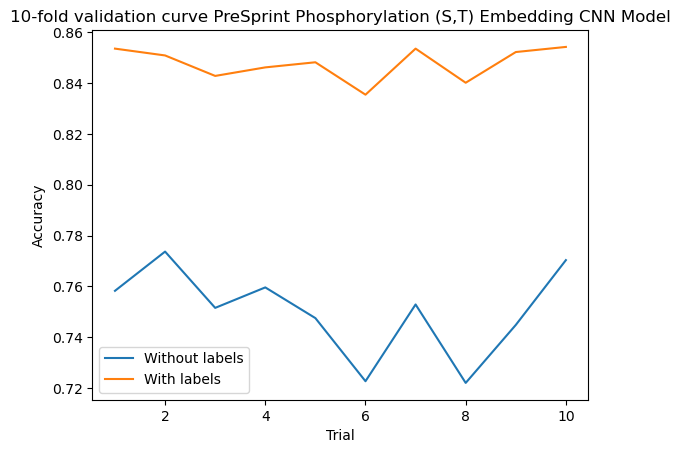

46/46 [==============================] - 0s 4ms/step
        AUC     AUPRC  Accuracy    Recall  Precision       MCC        F1  \
0  0.836342  0.815722  0.752577  0.790230   0.719895  0.508444  0.753425   
1  0.854934  0.832800  0.778007  0.834019   0.750617  0.559390  0.790123   
2  0.849340  0.823775  0.764261  0.765928   0.760660  0.528532  0.763285   
3  0.848015  0.833189  0.762199  0.743555   0.777305  0.525098  0.760055   
4  0.858492  0.853859  0.775258  0.821183   0.751889  0.552893  0.785010   
5  0.843810  0.833377  0.764948  0.757997   0.764376  0.529805  0.761173   
6  0.855846  0.848932  0.770447  0.711888   0.799058  0.543054  0.752959   
7  0.834364  0.827764  0.749141  0.751026   0.750000  0.498267  0.750513   
8  0.835600  0.825086  0.760137  0.771546   0.756032  0.520327  0.763710   
9  0.806011  0.807335  0.738832  0.705146   0.751111  0.478099  0.727403   

   Specificity  
0     0.718050  
1     0.721763  
2     0.762619  
3     0.781337  
4     0.729396  
5     0.

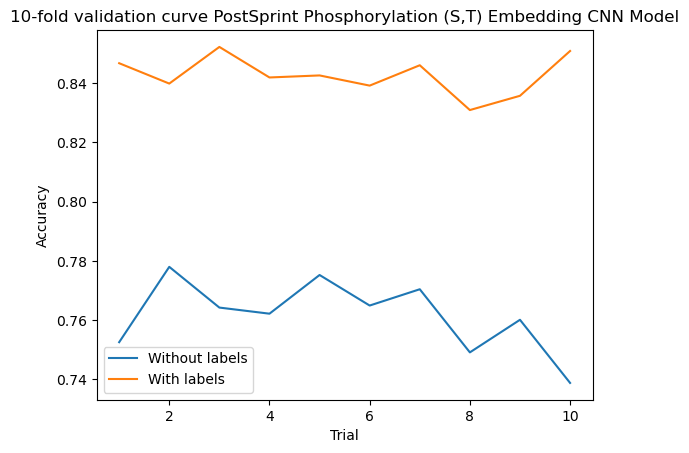

In [3]:
#Predict on test sets and obtain metrics
ptm='Phosphorylation (S,T)'
parent="Example_data"
sets=["PreSprint", "PostSprint"] #Different datasets that want to run
for set in sets:
    folder=f'{parent}/{set}'
    cnn_emb_metrics(folder)

In [ ]:
#Bulk metrics from multiple trials (with Average, STD and P-value)
All_df = pd.DataFrame(columns=["PTM", "Labels", "Stat", "AUC", "AUPRC", "Accuracy", "Recall", "Precision", "MCC", "F1", "Specificity" ])
ind=0
for set in sets:
    directory=f'{parent}/{set}'
    metrics=["AUC", "AUPRC", "Accuracy", "Recall", "Precision", "MCC", "F1", "Specificity"]

    df_with_labels = pd.read_csv(f"{directory}/{set}_10-fold_validation_with_labels.csv", index_col=0)
    df_without_labels = pd.read_csv(f"{directory}/{set}_10-fold_validation_no_labels.csv", index_col=0)

    arraylist=[]
    harray=np.array([set, np.nan, np.nan, np.nan, np.nan])
    larray=np.array(["No labels", np.nan, "Labels", np.nan, np.nan])
    sarray=np.array(["Average", "STD", "Average", "STD", "P value"])
    arraylist.append(harray)
    arraylist.append(larray)
    arraylist.append(sarray)
    for metric in metrics:
        with_labels = np.average(df_with_labels[metric])
        wl_STD = np.std(df_with_labels[metric])
    
        without_labels = np.average(df_without_labels[metric])
        nl_STD = np.std(df_without_labels[metric])

        test, pvalue=scipy.stats.ttest_ind(df_with_labels[metric], df_without_labels[metric], equal_var=False)
        marray=np.array([without_labels, nl_STD, with_labels, wl_STD, pvalue])
        arraylist.append(marray)
        
    karray=np.stack(arraylist, axis=1)
    working_df = pd.DataFrame(karray, columns=["PTM", "Labels", "Stat", "AUC", "AUPRC", "Accuracy", "Recall", "Precision", "MCC", "F1", "Specificity" ])
    All_df = pd.concat([All_df, working_df])
    ind+=4
print(All_df)
All_df.to_csv(f"{parent}/{ptm}_All_PTM_results_avg_std_pvalue.csv")

In [16]:
def auc_curves(model, trial_num, folder=''):
    # roc curve and auc
    directory=f'{folder}/Trial{trial_num}'
    labeled_model = tf.keras.models.load_model(f"{directory}/emb_CNN_with_labels_{trial_num}.h5")
    unlabeled_model = tf.keras.models.load_model(f"{directory}/emb_CNN_no_labels_{trial_num}.h5")
        
    x_test_labeled = np.load(f"{directory}/x_test_with_labels_{trial_num}.npy", allow_pickle = True)
    y_test_labeled = np.load(f"{directory}/y_test_with_labels_{trial_num}.npy", allow_pickle = True).astype('float32')
    x_test_unlabeled = np.load(f"{directory}/x_test_with_labels_{trial_num}.npy", allow_pickle = True)
    y_test_unlabeled = np.load(f"{directory}/y_test_with_labels_{trial_num}.npy", allow_pickle = True).astype('float32')
    
    subdir = "All_ROC"
    path=f'{folder}/{subdir}'
    try:
        path=os.mkdir(f'{path}') 
    except OSError as error:
        print(error)
    
    #AUC curve
    # labeled data
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test_labeled))]
    # predict probabilities
    lr_probs = labeled_model.predict(x_test_labeled)
    # calculate scores
    ns_auc = roc_auc_score(y_test_labeled, ns_probs)
    lr_auc = roc_auc_score(y_test_labeled, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('With Labels: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test_labeled, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test_labeled, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='With Labels')

    # unlabeled data
    # predict probabilities
    ulr_probs = unlabeled_model.predict(x_test_unlabeled)
    # calculate scores
    ulr_auc = roc_auc_score(y_test_unlabeled, ulr_probs)
    # summarize scores
    print('Without Labels: ROC AUC=%.3f' % (ulr_auc))
    # calculate roc curves
    ulr_fpr, ulr_tpr, _ = roc_curve(y_test_unlabeled, ulr_probs)
    # plot the roc curve for the model
    plt.plot(ulr_fpr, ulr_tpr, marker='.', label='Without Labels')

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot and save it to specified directory
    plt.title(f"AUC Curve for {model} Embedding CNN Model")
    plt.savefig(f"{path}/{model}_auc-curve_{trial_num}.pdf", transparent=True)  #Adjust to humans if doing humans dataset
    plt.show()
    
    #AUCPR curve
    # labeled data

    # predict class values
    yhat = labeled_model.predict(x_test_labeled)
    yhat = tf.argmax(yhat, axis=-1)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test_labeled, lr_probs)
    lr_f1, lr_auc = f1_score(y_test_labeled, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('With Labels: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test_labeled[y_test_labeled==1]) / len(y_test_labeled)
    plt.plot([0, 1], [0, 0], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='With Labels')

    # unlabeled data
    # predict probabilities
    # predict class values
    uyhat = unlabeled_model.predict(x_test_unlabeled)
    uyhat = tf.argmax(uyhat, axis=-1)
    ulr_precision, ulr_recall, _ = precision_recall_curve(y_test_unlabeled, ulr_probs)
    ulr_f1, ulr_auc = f1_score(y_test_unlabeled, uyhat), auc(ulr_recall, ulr_precision)
    # summarize scores
    print('Without Labels: f1=%.3f auc=%.3f' % (ulr_f1, ulr_auc))
    # plot the precision-recall curves
    plt.plot(ulr_recall, ulr_precision, marker='.', label='Without Labels')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot and save it to specified directory
    plt.title(f"AUPRC Curve for {model} Embedding CNN Model")
    plt.savefig(f"{path}/{model}_auprc-curve_{trial_num}.pdf", transparent=True) #Adjust to humans if doing humans dataset
    plt.show()

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 0s 4ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.924
47/47 [==============================] - 0s 4ms/step
Without Labels: ROC AUC=0.840


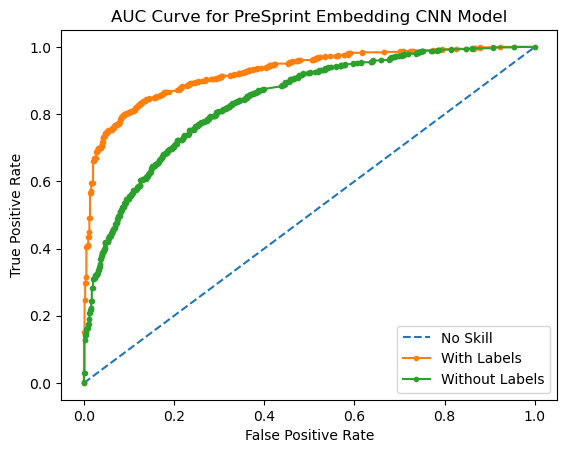

47/47 [==============================] - 0s 5ms/step
With Labels: f1=0.000 auc=0.933
47/47 [==============================] - 0s 4ms/step
Without Labels: f1=0.000 auc=0.840


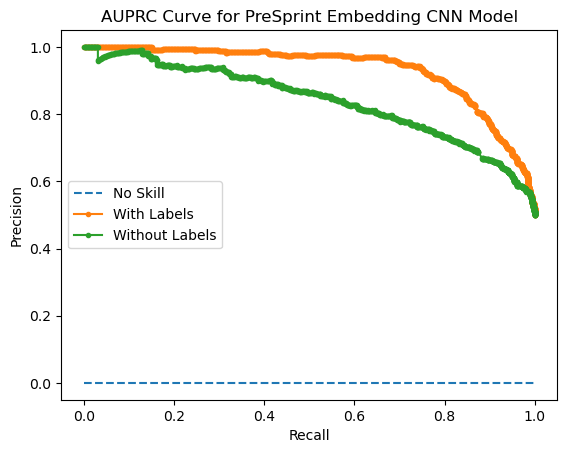

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 0s 4ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.922
47/47 [==============================] - 0s 4ms/step
Without Labels: ROC AUC=0.843


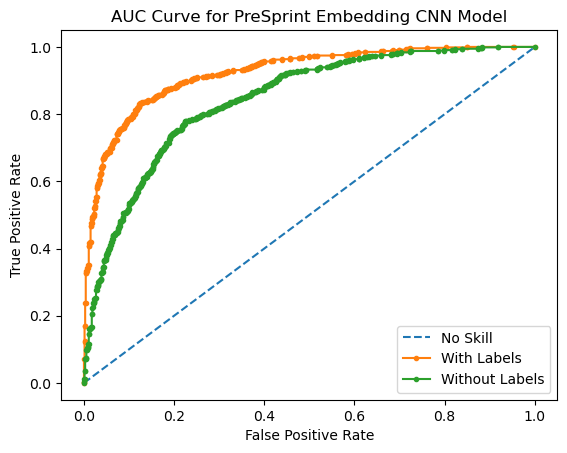

47/47 [==============================] - 0s 6ms/step
With Labels: f1=0.000 auc=0.924
47/47 [==============================] - 1s 15ms/step
Without Labels: f1=0.000 auc=0.828


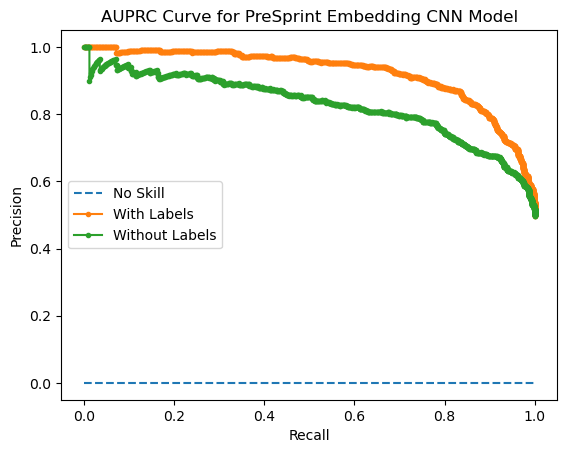

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 0s 4ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.918
47/47 [==============================] - 0s 5ms/step
Without Labels: ROC AUC=0.839


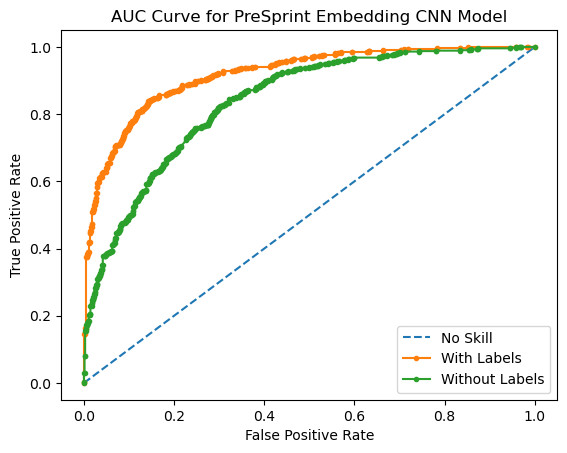

47/47 [==============================] - 0s 5ms/step
With Labels: f1=0.000 auc=0.918
47/47 [==============================] - 0s 7ms/step
Without Labels: f1=0.000 auc=0.825


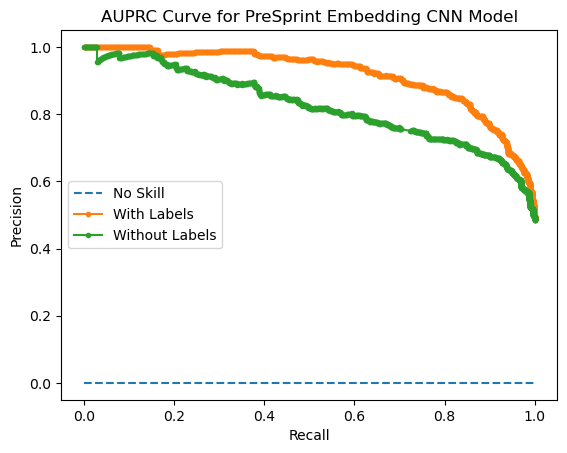

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 14ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.929
47/47 [==============================] - 1s 14ms/step
Without Labels: ROC AUC=0.839


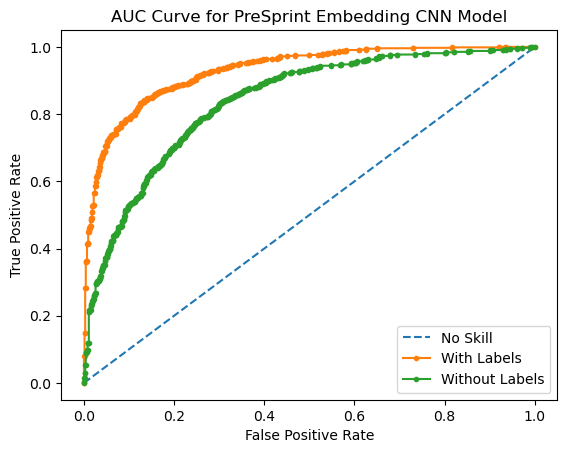

47/47 [==============================] - 0s 8ms/step
With Labels: f1=0.000 auc=0.932
47/47 [==============================] - 1s 9ms/step
Without Labels: f1=0.000 auc=0.830


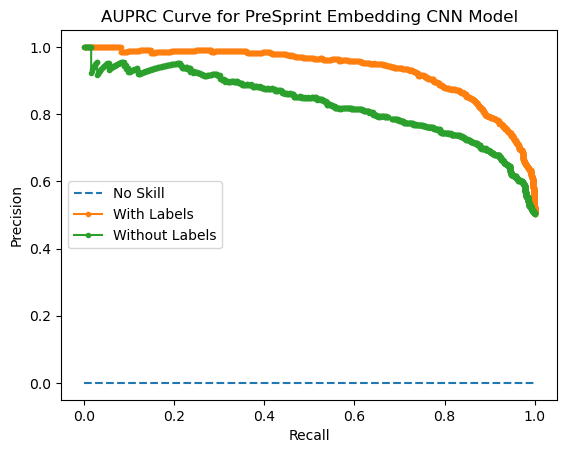

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 9ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.917
47/47 [==============================] - 0s 5ms/step
Without Labels: ROC AUC=0.828


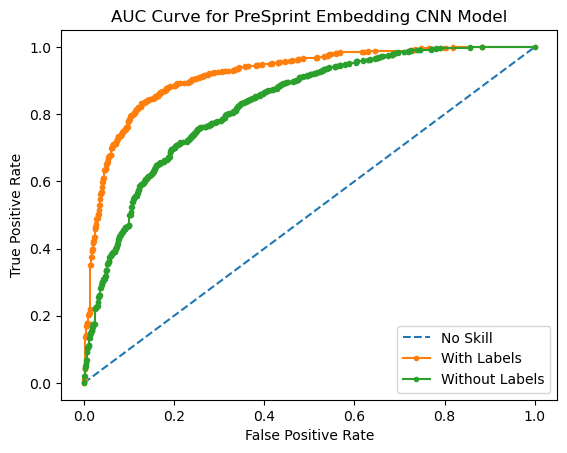

47/47 [==============================] - 1s 10ms/step
With Labels: f1=0.000 auc=0.905
47/47 [==============================] - 0s 5ms/step
Without Labels: f1=0.000 auc=0.805


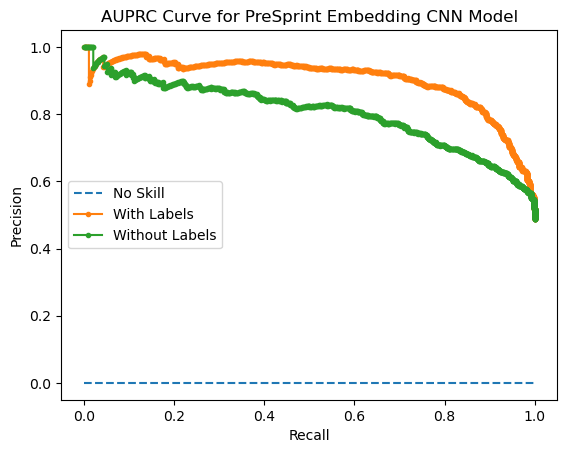

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 0s 4ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.913
47/47 [==============================] - 0s 4ms/step
Without Labels: ROC AUC=0.799


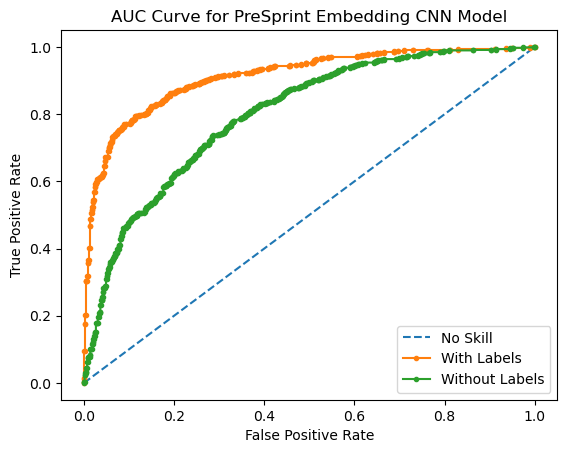

47/47 [==============================] - 1s 17ms/step
With Labels: f1=0.000 auc=0.925
47/47 [==============================] - 0s 4ms/step
Without Labels: f1=0.000 auc=0.790


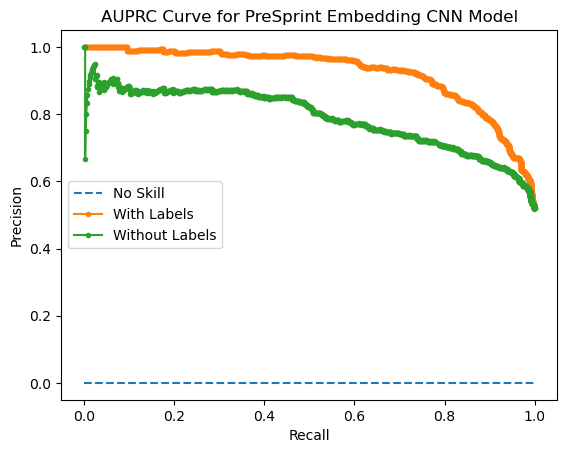

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 17ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.925
47/47 [==============================] - 1s 21ms/step
Without Labels: ROC AUC=0.828


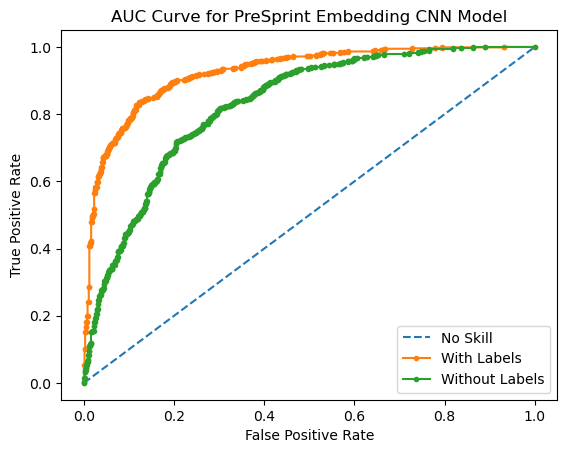

47/47 [==============================] - 2s 30ms/step
With Labels: f1=0.000 auc=0.921
47/47 [==============================] - 2s 32ms/step
Without Labels: f1=0.000 auc=0.799


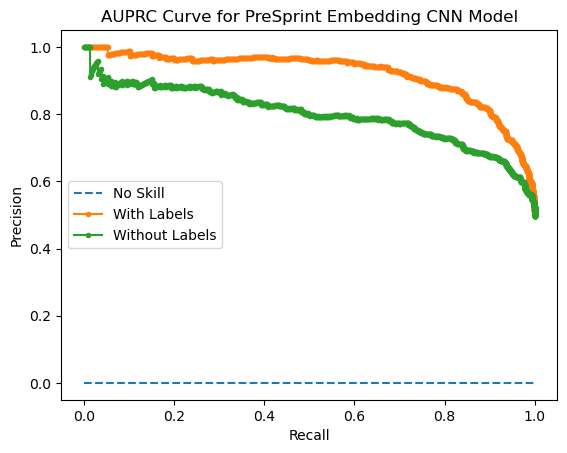

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 27ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.914
47/47 [==============================] - 0s 4ms/step
Without Labels: ROC AUC=0.807


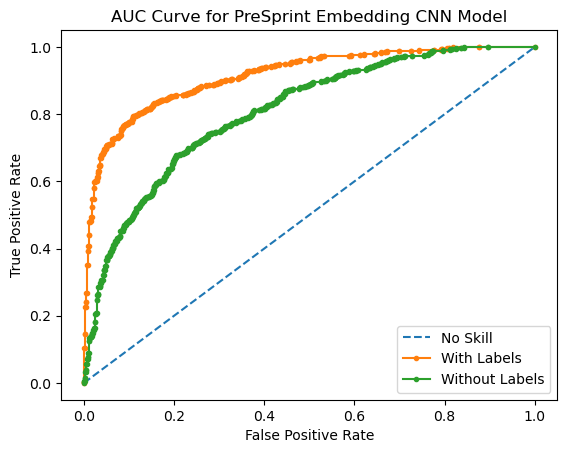

47/47 [==============================] - 0s 7ms/step
With Labels: f1=0.000 auc=0.921
47/47 [==============================] - 0s 5ms/step
Without Labels: f1=0.000 auc=0.793


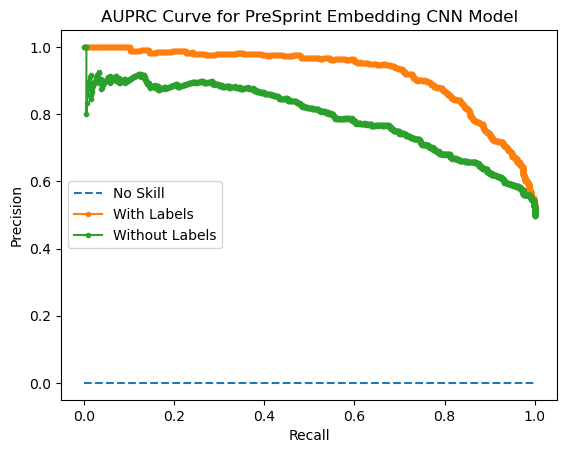

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 19ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.922
47/47 [==============================] - 1s 18ms/step
Without Labels: ROC AUC=0.827


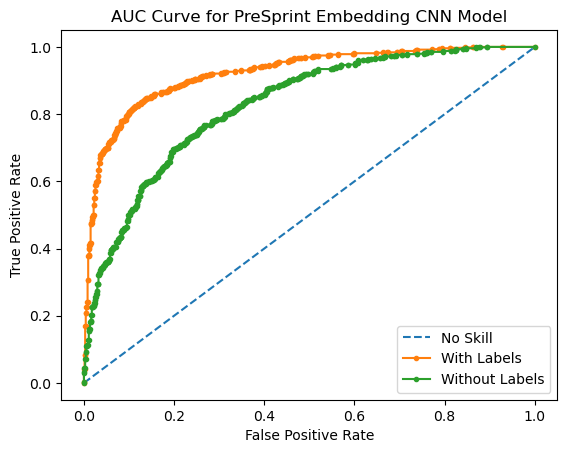

47/47 [==============================] - 1s 26ms/step
With Labels: f1=0.000 auc=0.923
47/47 [==============================] - 0s 8ms/step
Without Labels: f1=0.000 auc=0.819


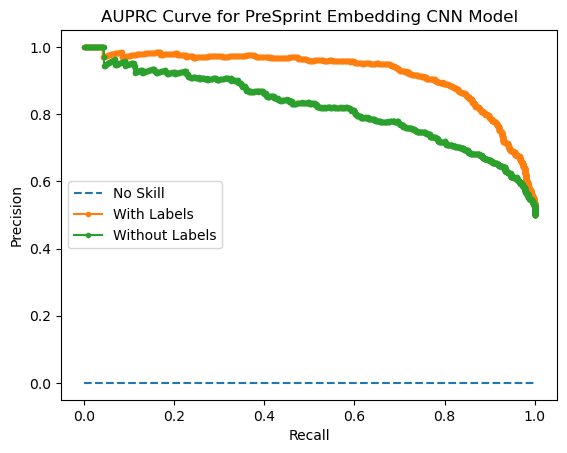

[WinError 183] Cannot create a file when that file already exists: 'Example_data/PreSprint/All_ROC'
47/47 [==============================] - 1s 16ms/step
No Skill: ROC AUC=0.500
With Labels: ROC AUC=0.932
47/47 [==============================] - 2s 31ms/step
Without Labels: ROC AUC=0.846


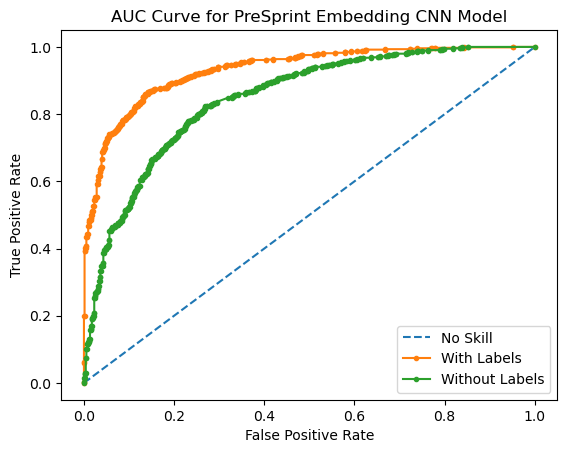

47/47 [==============================] - 1s 12ms/step
With Labels: f1=0.000 auc=0.936
47/47 [==============================] - 1s 13ms/step
Without Labels: f1=0.000 auc=0.831


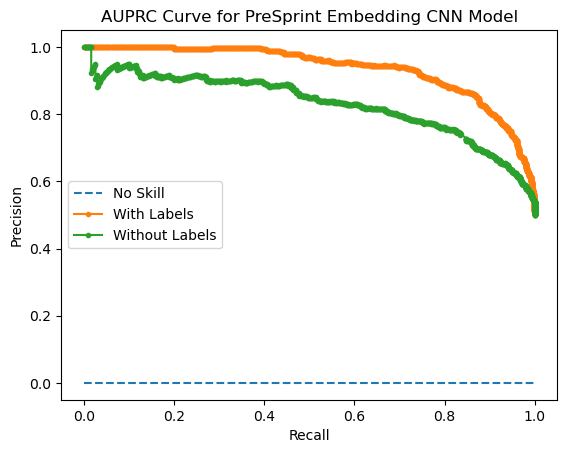

In [20]:
for trial_num in range (1, 11):
    auc_curves("PreSprint", trial_num, folder='Example_data/PreSprint') #Add the model name and folder here
    #auc_curves("PostSprint", trial_num, folder='Example_data/PostSprint') #Add the model name and folder here